In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            ConfusionMatrixDisplay, accuracy_score, f1_score)

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Uyarıları kapat
warnings.filterwarnings('ignore')

# ============================================================================
# YAPILANDIRMA PARAMETRELERİ
# ============================================================================
# Örneklem boyutunu 1.5 Milyon olarak güncelledik
SAMPLE_SIZE = 1500000  
TEST_RATIO = 0.2
RANDOM_STATE = 42
PCA_COMPONENTS = 0.95 

# XGBoost Temel Parametreleri
MODEL_PARAMS = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

print("✓ Kütüphaneler yüklendi.")
print(f"✓ Hedef Örnek Boyutu: {SAMPLE_SIZE:,}")
print(f"✓ Test Oranı: {TEST_RATIO}")

✓ Kütüphaneler yüklendi.
✓ Hedef Örnek Boyutu: 1,500,000
✓ Test Oranı: 0.2


In [2]:
def load_and_split_data(filepath, sample_size, test_size, random_state):
    """
    Veriyi yükler. Severity 1, 3, 4'ün tamamını alır; 
    Severity 2'den ise 1.3M örnek seçer ve birleştirir.
    """
    print("\n" + "="*80)
    print("VERİ YÜKLEME VE ÖZELLEŞTİRİLMİŞ ÖRNEKLEME")
    print("="*80)
    
    # 1. Tüm veriyi yükle
    print("→ Veri seti okunuyor (bu işlem RAM boyutuna göre zaman alabilir)...")
    raw_data = pd.read_csv(filepath)
    print(f"→ Ham veri toplam satır sayısı: {len(raw_data):,}")
    
    # 2. Sınıflara ayır
    sev1 = raw_data[raw_data['Severity'] == 1]
    sev2 = raw_data[raw_data['Severity'] == 2]
    sev3 = raw_data[raw_data['Severity'] == 3]
    sev4 = raw_data[raw_data['Severity'] == 4]
    
    print(f"\n  Orijinal Dağılım:")
    print(f"  - Severity 1: {len(sev1):,} (Tamamı alınacak)")
    print(f"  - Severity 2: {len(sev2):,} (1.3M alınacak)")
    print(f"  - Severity 3: {len(sev3):,} (Tamamı alınacak)")
    print(f"  - Severity 4: {len(sev4):,} (Tamamı alınacak)")
    
    # 3. Severity 2'den 1.3 Milyon örnek seç (Downsampling)
    target_sev2_count = 1300000
    
    if len(sev2) > target_sev2_count:
        sev2_sampled = sev2.sample(n=target_sev2_count, random_state=random_state)
    else:
        sev2_sampled = sev2.copy()
        print(f"! Uyarı: Severity 2 verisi 1.3M'dan az ({len(sev2)}). Tamamı alındı.")
        
    # 4. Verileri Birleştir
    sampled_data = pd.concat([sev1, sev2_sampled, sev3, sev4], axis=0)
    
    # 5. Veriyi Karıştır (Shuffle) - Sıralı kalmaması için önemli
    sampled_data = sampled_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Bellek temizliği
    del raw_data, sev1, sev2, sev3, sev4, sev2_sampled
    
    print(f"\n→ Nihai çalışma veri seti boyutu: {len(sampled_data):,}")
    
    # 6. Train/Test Split
    features = sampled_data.drop('Severity', axis=1)
    target = sampled_data['Severity']
    
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=target
    )
    
    print(f"→ Eğitim seti: {X_train.shape[0]:,} satır")
    print(f"→ Test seti:   {X_test.shape[0]:,} satır")
    
    return X_train, X_test, y_train, y_test

In [3]:
def create_all_features(data):
    """Tüm özellik mühendisliği işlemlerini uygular."""
    print("\n" + "-"*80)
    print("ÖZELLİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)")
    print("-"*80)
    
    df = data.copy()
    
    # 1. Zaman Tabanlı Özellikler
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    
    df['Hour_of_Day'] = df['Start_Time'].dt.hour
    df['Day_Name'] = df['Start_Time'].dt.day_name()
    df['Is_Weekend_Day'] = df['Day_Name'].isin(['Saturday', 'Sunday']).astype(int)
    
    rush_hours = [7, 8, 9, 16, 17, 18]
    df['During_Rush_Hour'] = df['Hour_of_Day'].isin(rush_hours).astype(int)
    
    duration_seconds = (df['End_Time'] - df['Start_Time']).dt.total_seconds()
    df['Accident_Duration_Min'] = (duration_seconds / 60).clip(lower=0)
    
    # 2. Hava Durumu Özellikleri
    if 'Weather_Condition' in df.columns:
        df['Weather_Condition'] = df['Weather_Condition'].fillna('Clear')
        adverse_keywords = ['rain', 'snow', 'storm', 'thunder', 'fog', 'ice', 'sleet', 'hail']
        pattern = '|'.join(adverse_keywords)
        df['Adverse_Weather'] = df['Weather_Condition'].str.lower().str.contains(pattern, na=False).astype(int)
    
    if 'Precipitation(in)' in df.columns:
        df['Precipitation(in)'] = df['Precipitation(in)'].fillna(0.0)
        df['Has_Precipitation'] = (df['Precipitation(in)'] > 0).astype(int)

    # 3. Trafik Özellikleri
    if all(col in df.columns for col in ['Traffic_Signal', 'Stop']):
        df['Signal_Stop_Present'] = ((df['Traffic_Signal'] == True) | (df['Stop'] == True)).astype(int)
    
    if 'Junction' in df.columns:
        df['Junction'] = df['Junction'].astype(int)

    # 4. Şiddet Göstergeleri
    if all(col in df.columns for col in ['Distance(mi)', 'Accident_Duration_Min']):
        dist_thresh = df['Distance(mi)'].quantile(0.75)
        dur_thresh = df['Accident_Duration_Min'].quantile(0.75)
        df['High_Impact_Incident'] = ((df['Distance(mi)'] > dist_thresh) & 
                                      (df['Accident_Duration_Min'] > dur_thresh)).astype(int)
    
    print("→ Özellik mühendisliği tamamlandı.")
    return df

In [4]:
def preprocess_data(X_train, X_test):
    """Veri ön işleme adımlarını yönetir."""
    print("\n" + "-"*80)
    print("VERİ TEMİZLEME VE ÖN İŞLEME")
    print("-"*80)
    
    # 1. Gereksiz Sütunların Temizlenmesi
    columns_to_remove = [
        'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 
        'Country', 'Start_Time', 'End_Time', 'Timezone', 'Airport_Code',
        'Weather_Timestamp', 'Wind_Chill(F)', 'Street', 'Description',
        'Weather_Condition', 'City'
    ]
    X_train = X_train.drop(columns=columns_to_remove, errors='ignore')
    X_test = X_test.drop(columns=columns_to_remove, errors='ignore')
    
    # 2. Aykırı Değerler (Clipping)
    numerical_cols = ['Temperature(F)', 'Wind_Speed(mph)', 'Precipitation(in)',
                      'Distance(mi)', 'Accident_Duration_Min', 'Pressure(in)',
                      'Humidity(%)', 'Visibility(mi)']
    
    available_cols = [col for col in numerical_cols if col in X_train.columns]
    
    for column in available_cols:
        lower = X_train[column].quantile(0.01)
        upper = X_train[column].quantile(0.99)
        X_train[column] = X_train[column].clip(lower=lower, upper=upper)
        X_test[column] = X_test[column].clip(lower=lower, upper=upper)
    
    # 3. Eksik Değer Doldurma (Imputation)
    fill_strategy = {}
    for column in X_train.columns:
        if pd.api.types.is_numeric_dtype(X_train[column]):
            fill_strategy[column] = X_train[column].median()
        else:
            mode_val = X_train[column].mode()
            fill_strategy[column] = mode_val[0] if len(mode_val) > 0 else 'Unknown'
            
    X_train = X_train.fillna(value=fill_strategy)
    X_test = X_test.fillna(value=fill_strategy)
    
    print(f"→ Temizlenmiş özellik sayısı: {X_train.shape[1]}")
    return X_train, X_test

In [5]:
def encode_scale_pca(X_train, X_test, pca_variance=0.95):
    """Encoding, Scaling ve PCA uygular."""
    print("\n" + "-"*80)
    print("ENCODING, SCALING VE PCA")
    print("-"*80)
    
    # 1. Encoding
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"✓ Kategorik değişkenler kodlanıyor: {len(categorical_cols)} adet")
    
    X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
    X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
    
    # Sütun eşitleme
    missing_cols = set(X_train_enc.columns) - set(X_test_enc.columns)
    for c in missing_cols: X_test_enc[c] = 0
    X_test_enc = X_test_enc[X_train_enc.columns]
    
    # 2. Scaling
    numeric_cols = X_train_enc.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    
    X_train_scaled = X_train_enc.copy()
    X_test_scaled = X_test_enc.copy()
    
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train_enc[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test_enc[numeric_cols])
    
    # 3. PCA
    print(f"✓ PCA uygulanıyor (Varyans: %{pca_variance*100})")
    pca = PCA(n_components=pca_variance, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    print(f"→ Orijinal Özellik Sayısı: {X_train_scaled.shape[1]}")
    print(f"→ PCA Sonrası Bileşen Sayısı: {pca.n_components_}")
    
    return X_train_scaled, X_test_scaled, X_train_pca, X_test_pca

In [6]:
def evaluate_and_plot(model, X_test, y_test, model_name):
    """Model performansını ölçer ve matrisi çizer."""
    print("\n" + "="*60)
    print(f"MODEL DEĞERLENDİRME: {model_name}")
    print("="*60)
    
    y_test_adj = y_test - 1  # 1-4 arasını 0-3 yap
    start = time.time()
    preds = model.predict(X_test)
    pred_time = time.time() - start
    
    acc = accuracy_score(y_test_adj, preds)
    f1 = f1_score(y_test_adj, preds, average='weighted')
    
    print(f"→ Tahmin Süresi: {pred_time:.2f} sn")
    print(f"→ Accuracy: {acc:.4f}")
    print(f"→ F1-Score (Weighted): {f1:.4f}")
    
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test_adj, preds, target_names=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_adj, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4'])
    fig, ax = plt.subplots(figsize=(6, 5))
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()
    
    return {'Model': model_name, 'Accuracy': acc, 'F1_Weighted': f1}

In [7]:
# Dosya adını kendine göre düzenle
csv_path = 'US_Accidents_March23.csv' 

# 1. Yükleme ve Bölme
X_train, X_test, y_train, y_test = load_and_split_data(csv_path, SAMPLE_SIZE, TEST_RATIO, RANDOM_STATE)

# 2. Feature Engineering
X_train_feat = create_all_features(X_train)
X_test_feat = create_all_features(X_test)

# 3. Temizleme
X_train_clean, X_test_clean = preprocess_data(X_train_feat, X_test_feat)

# 4. Encoding/Scaling/PCA
X_train_final, X_test_final, X_train_pca, X_test_pca = encode_scale_pca(
    X_train_clean, X_test_clean, PCA_COMPONENTS
)

# Sonuçları saklamak için liste
results_list = []


VERİ YÜKLEME VE ÖZELLEŞTİRİLMİŞ ÖRNEKLEME
→ Veri seti okunuyor (bu işlem RAM boyutuna göre zaman alabilir)...
→ Ham veri toplam satır sayısı: 7,728,394

  Orijinal Dağılım:
  - Severity 1: 67,366 (Tamamı alınacak)
  - Severity 2: 6,156,981 (1.3M alınacak)
  - Severity 3: 1,299,337 (Tamamı alınacak)
  - Severity 4: 204,710 (Tamamı alınacak)

→ Nihai çalışma veri seti boyutu: 2,871,413
→ Eğitim seti: 2,297,130 satır
→ Test seti:   574,283 satır

--------------------------------------------------------------------------------
ÖZELLİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)
--------------------------------------------------------------------------------
→ Özellik mühendisliği tamamlandı.

--------------------------------------------------------------------------------
ÖZELLİK MÜHENDİSLİĞİ (FEATURE ENGINEERING)
--------------------------------------------------------------------------------
→ Özellik mühendisliği tamamlandı.

---------------------------------------------------------------------

Baseline 1 Eğitiliyor...

MODEL DEĞERLENDİRME: Baseline (Majority)
→ Tahmin Süresi: 0.00 sn
→ Accuracy: 0.4527
→ F1-Score (Weighted): 0.2822

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Sev 1       0.00      0.00      0.00     13473
       Sev 2       0.45      1.00      0.62    260000
       Sev 3       0.00      0.00      0.00    259868
       Sev 4       0.00      0.00      0.00     40942

    accuracy                           0.45    574283
   macro avg       0.11      0.25      0.16    574283
weighted avg       0.20      0.45      0.28    574283



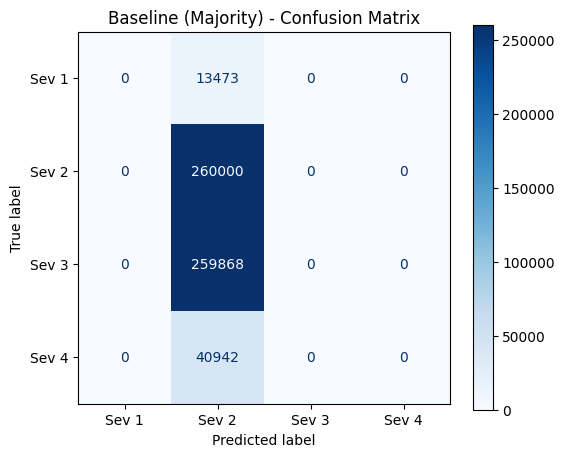

In [8]:
class MajorityClassClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.majority_ = pd.Series(y).mode()[0]
        return self
    def predict(self, X):
        return np.full(X.shape[0], self.majority_)

print("Baseline 1 Eğitiliyor...")
baseline_model = MajorityClassClassifier()
baseline_model.fit(X_train_final, y_train - 1)

res = evaluate_and_plot(baseline_model, X_test_final, y_test, "Baseline (Majority)")
results_list.append(res)

Baseline 2 (Logistic Regression) Eğitiliyor...
Eğitim Süresi: 30.56 sn

MODEL DEĞERLENDİRME: Logistic Regression (PCA)
→ Tahmin Süresi: 0.04 sn
→ Accuracy: 0.6053
→ F1-Score (Weighted): 0.5828

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Sev 1       0.47      0.02      0.04     13473
       Sev 2       0.60      0.60      0.60    260000
       Sev 3       0.61      0.72      0.66    259868
       Sev 4       0.44      0.08      0.13     40942

    accuracy                           0.61    574283
   macro avg       0.53      0.36      0.36    574283
weighted avg       0.59      0.61      0.58    574283



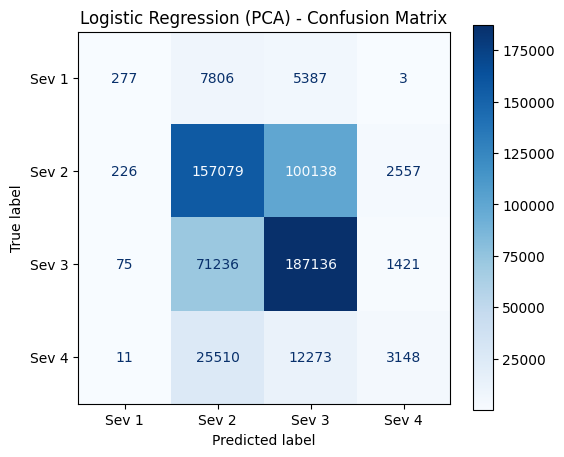

In [9]:
print("Baseline 2 (Logistic Regression) Eğitiliyor...")
log_model = LogisticRegression(max_iter=500, n_jobs=-1, random_state=RANDOM_STATE)

start = time.time()
log_model.fit(X_train_pca, y_train - 1)
print(f"Eğitim Süresi: {time.time()-start:.2f} sn")

res = evaluate_and_plot(log_model, X_test_pca, y_test, "Logistic Regression (PCA)")
results_list.append(res)

Standard XGBoost Eğitiliyor (Sampling Yok)...
Eğitim Süresi: 60.38 sn

MODEL DEĞERLENDİRME: Standard XGBoost
→ Tahmin Süresi: 0.99 sn
→ Accuracy: 0.7753
→ F1-Score (Weighted): 0.7654

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Sev 1       0.71      0.33      0.45     13473
       Sev 2       0.80      0.76      0.78    260000
       Sev 3       0.77      0.88      0.82    259868
       Sev 4       0.63      0.31      0.42     40942

    accuracy                           0.78    574283
   macro avg       0.73      0.57      0.62    574283
weighted avg       0.77      0.78      0.77    574283



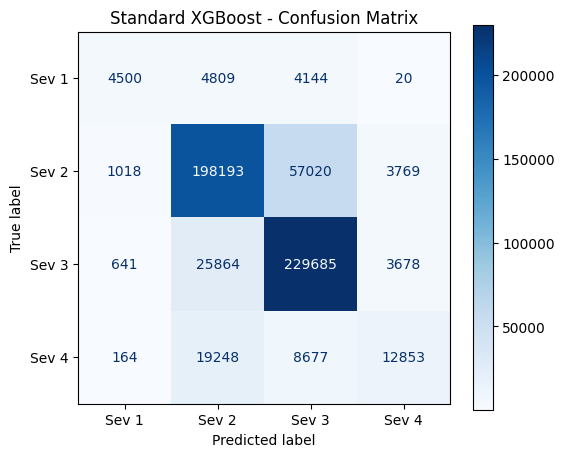

In [10]:
print("Standard XGBoost Eğitiliyor (Sampling Yok)...")

# Standart XGBoost modeli
xgb_std = xgb.XGBClassifier(**MODEL_PARAMS)

start = time.time()
xgb_std.fit(X_train_final, y_train - 1)
print(f"Eğitim Süresi: {time.time()-start:.2f} sn")

res = evaluate_and_plot(xgb_std, X_test_final, y_test, "Standard XGBoost")
results_list.append(res)

Bagging Classifier Eğitiliyor...
Eğitim Süresi: 236.76 sn

MODEL DEĞERLENDİRME: Bagging Classifier
→ Tahmin Süresi: 4.00 sn
→ Accuracy: 0.8259
→ F1-Score (Weighted): 0.8220

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Sev 1       0.75      0.50      0.60     13473
       Sev 2       0.84      0.83      0.83    260000
       Sev 3       0.84      0.89      0.86    259868
       Sev 4       0.67      0.49      0.56     40942

    accuracy                           0.83    574283
   macro avg       0.77      0.68      0.72    574283
weighted avg       0.82      0.83      0.82    574283



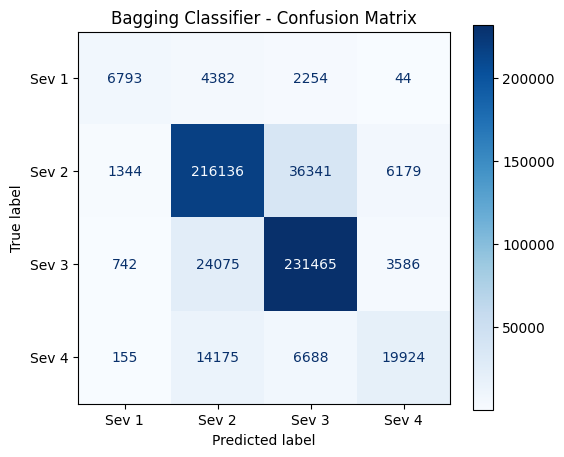

In [11]:
print("Bagging Classifier Eğitiliyor...")

# Bagging Classifier Tanımlama
# Not: Çok büyük veride yavaş olabilir, n_estimators'ı optimize ettik.
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=20,  # Hız için makul bir sayı
    max_samples=0.5,  # Her estimator verinin %50'sini görsün
    n_jobs=-1,
    random_state=RANDOM_STATE
)

start = time.time()
bagging_clf.fit(X_train_final, y_train - 1)
print(f"Eğitim Süresi: {time.time()-start:.2f} sn")

res = evaluate_and_plot(bagging_clf, X_test_final, y_test, "Bagging Classifier")
results_list.append(res)

SMOTE + XGBoost Eğitiliyor...
Eğitim Süresi: 2272.14 sn

MODEL DEĞERLENDİRME: SMOTE + XGBoost
→ Tahmin Süresi: 5.25 sn
→ Accuracy: 0.7210
→ F1-Score (Weighted): 0.7329

Sınıflandırma Raporu:
              precision    recall  f1-score   support

       Sev 1       0.27      0.75      0.40     13473
       Sev 2       0.84      0.64      0.72    260000
       Sev 3       0.78      0.81      0.80    259868
       Sev 4       0.39      0.65      0.48     40942

    accuracy                           0.72    574283
   macro avg       0.57      0.71      0.60    574283
weighted avg       0.77      0.72      0.73    574283



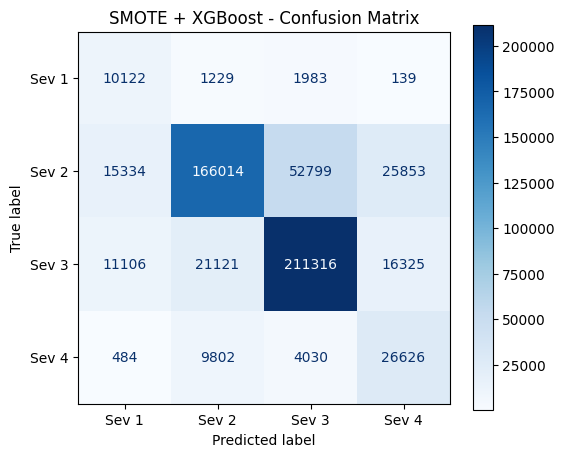

In [12]:
print("SMOTE + XGBoost Eğitiliyor...")

pipeline_smote = ImbPipeline([
    ('sampling', SMOTE(random_state=RANDOM_STATE, n_jobs=-1)),
    ('classification', xgb.XGBClassifier(**MODEL_PARAMS))
])

start = time.time()
pipeline_smote.fit(X_train_final, y_train - 1)
print(f"Eğitim Süresi: {time.time()-start:.2f} sn")

res = evaluate_and_plot(pipeline_smote, X_test_final, y_test, "SMOTE + XGBoost")
results_list.append(res)